In [4]:
from ..server.rb87_mot_model.py import plot_results

ImportError: attempted relative import with no known parent package

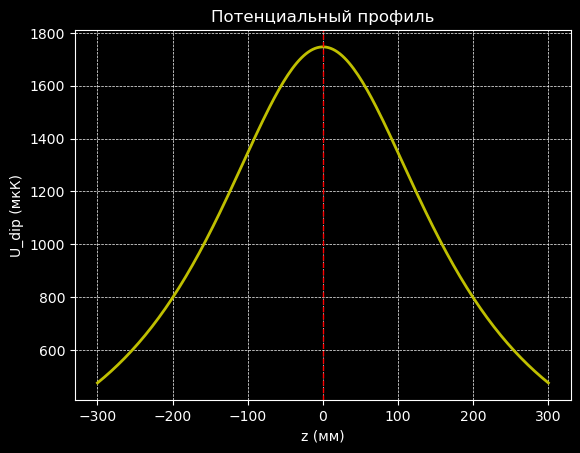

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Исходные параметры
s = 1231  # mm
W_0 = 243 * 10**(-3)  # mm
z_R = math.pi * (W_0**2) / (1012 * 10**(-6))  # mm
w_0 = 296 * 10**(12)  # Hz
delta = 88 * 10**(12)  # Hz
Gamma = 3 * 10**6  # Hz
f = 50  # mm
P = 2  # W

# Рассчитываем новые параметры
W_0_new = W_0 * (f / (((s - f)**2 + z_R**2) ** 0.5))  # mm

# Функция потенциала
def U_dip(r, z):
    W = W_0_new * np.sqrt(1 + (z / z_R)**2)
    I = (2 * P / (math.pi * (W * 10**(-3))**2)) * np.exp((-2 * r**2) / ((W * 10**(-3))**2))
    U = ((3 * math.pi * (3 * 10**8)**2) / (2 * w_0**3)) * Gamma * ((1 / delta) - (1 / (2 * w_0 + delta))) * I / ((2 * math.pi)**3)
    return U / (1.38 * 10**(-23) * 10**(-6))

# Диапазон для z
z = np.linspace(-300, 300, 200)
U_values = np.array([U_dip(0, zi) for zi in z])

# Построение графика
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.set_xlabel('z (мм)')
ax.set_ylabel('U_dip (мкК)')
ax.set_title('Потенциальный профиль')

ax.plot(z, U_values, color='y', lw=2)
ax.axvline(0, color='r', linestyle='--', lw=1)  # Вертикальная линия в нуле
ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()